#**Predicting Future Customers of a Bank**
**Author:** Anne Marie Bogar<br/>
**Active Project Dates:** May 6-20, 2024<br/>
<br/>
##Summary
A Portuguese banking company conducted a marketing campaign (through phone calls) to gain customers. Given the data collected for each client (including demographic information and information on the campaign methods), three different machine learning models were implemented to predict whether or not a potential client would be likely to become a customer at the bank. The models implemented were: Logistic Regression, Decision Tree and Random Forest.
<br/><br/>
##Data
The features in the [dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing) are as follows:
1. **age:** _numerical_
2. **job:** _categorical by job type_ - admin., unknown, unemployed, management, housemaid, entrepreneur, student, blue-collar, self-employed, retired, technician, services
3. **marital:** _categorical_ - married, single, divorced
4. **education:** _categorical_ - primary, secondary, tertiary, unknown
5. **default:** _categorical_ - whether or not they have credit in default
6. **balance:** _numerical_ - average yearly bank balance in euros
7. **housing:** _categorical_ - whether or not they have a housing loan
8. **loan:** _categorical_ - whether or not they have a personal loan
9. **contact:** _categorical_ by how they were contacted - telephone, cellular, unknown
10. **day:** _numerical_ - the day of the month they were last contacted
11. **month:** _categorical_ - the month they were last contacted
12. **duration:** _numerical_ - last contact duration, in seconds
13. **campaign:** _numerical_ - number of contacts performed during this campaign
14. **pdays:** _numerical_ - number of days since contact was last contacted from a previous campaign
15. **previous:** _numerical_ - number of contacts performed before this campaign
16. **poutcome:** _categorical by outcome of previous marketing campaign_ - failure, success, other, unknown

**Note:** _Duration_ should be excluded because the prediction is needed before contacting the potential client

#Import and Analyze Data

###Import libraries
- pandas and numpy for organizing the data
- seaborn ad matplotlib for visualizing the data
- LabelEncoder, MinMaxScaler, KNNImputer and math for preprocessing
- PCA for reducing dimensionality
- train_test_split for splitting the data into train, test and validation sets
- ADASYN for smoting the data to make it less imbalanced
- GridSearchCV for tuning hyperparameters
- LogisticRegression, DecisionTreeClassifier and RandomForestClassifier for the models
- accuracy_score, classification_report, confusion_matix and ConfusionMatrixDisplay for evaluation model

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import math
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics

###Import Data
- Import as a pandas dataframe
- Must use colon delimiter
- Divide dataframe into categorical and numerical features for EDA

In [106]:
df = pd.read_csv("bank-full.csv", delimiter=";")

categorical = df.select_dtypes(include=['object']).columns.tolist()
categorical.remove("y")
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical.remove("duration")

###Analyze Data
- print(df) -> look at complete dataframe
- print(df.describe()) -> look at stats (mean, std...)
- print(df.info()) -> look for missing values, data types...

In [ ]:
print(df)

In [ ]:
print(df.describe())

In [ ]:
print(df.info())

#Preprocessing
- Duplicates
- Missing Values
- Anomalies and Noise

###Remove Duplicates
- Check for any duplicate rows and remove if necessary

In [ ]:
df.duplicated().sum()

In [ ]:
df.drop_duplicates(inplace=True)

###Missing Values
- Check for percentage of missing values (categorical unknown value)

In [ ]:
for x in categorical:
  print(x+": "+str(list(df[x]).count('unknown')/df.shape[0]*100))

job: 0.6370131162770122
marital: 0.0
education: 4.1074074893278185
default: 0.0
housing: 0.0
loan: 0.0
contact: 28.798301298356595
month: 0.0
poutcome: 81.74780473778506
y: 0.0


###Noise Identification
- Histograms to show distribution of numerical features
- Box Plots to identify outliers and noise
- Pie Charts and Bar Charts to evaluate distribution of categorical features
- Bin numerical features to compare with categorical features
- Feature exploration -> for each feature, examine **yes** percentage for each value
- Noise reduction by binning the outliers

####Histograms
- Only for numerical features
1. Basic histogram to look at distribution of numerical values
2. Histogram separated by y values
3. Histogram of log transformed values for right-skewed features
4. Histogram of square root transformed values for right-skewed features


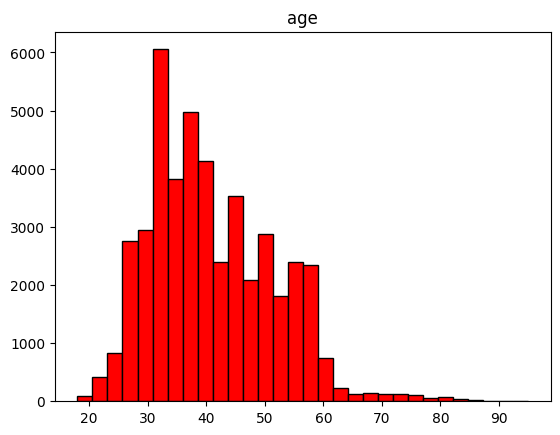

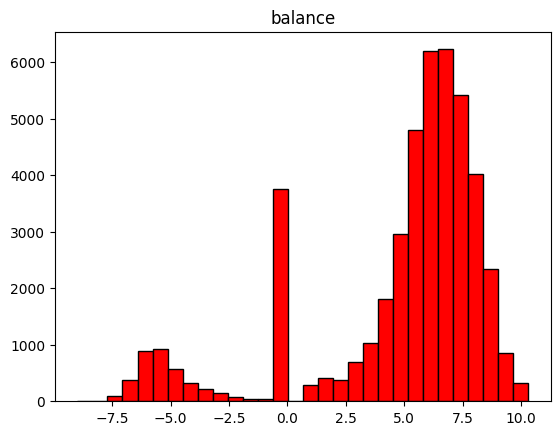

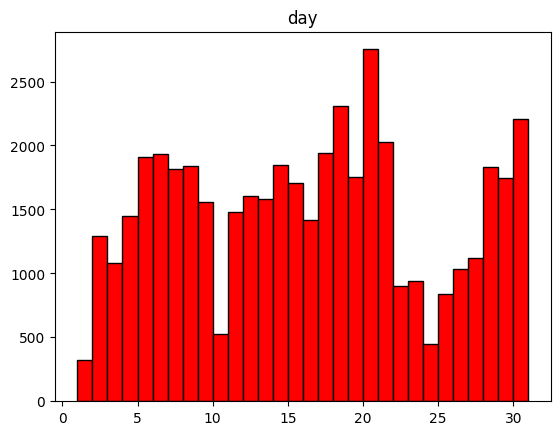

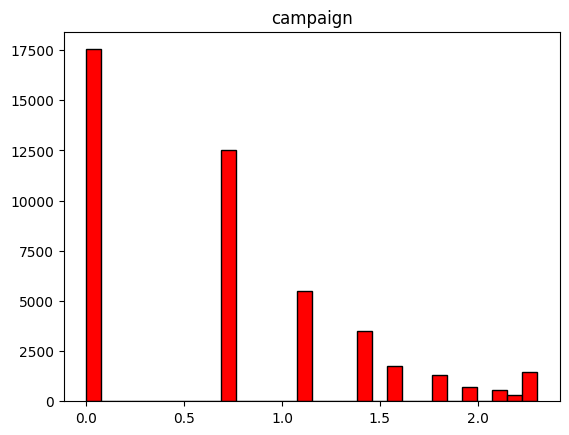

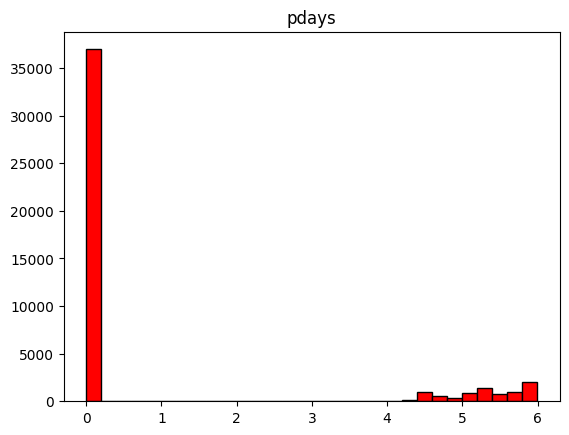

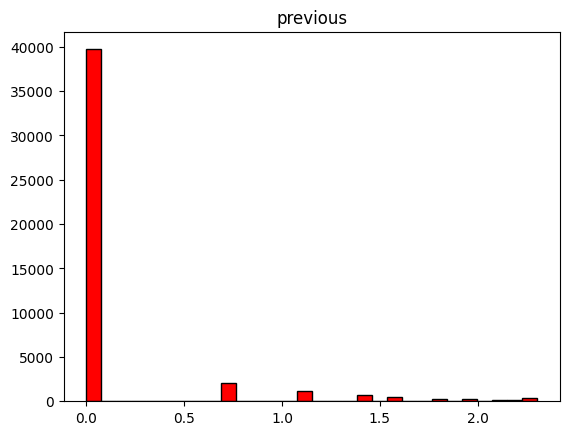

In [ ]:
def basic_hist(feat):
  plt.hist(df[feat], bins=30, color='red', edgecolor='black')
  plt.title(feat)
  plt.show()

for x in numerical:
  basic_hist(x)

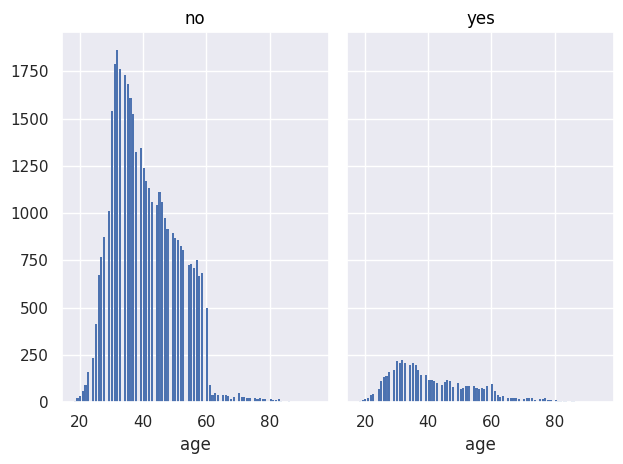

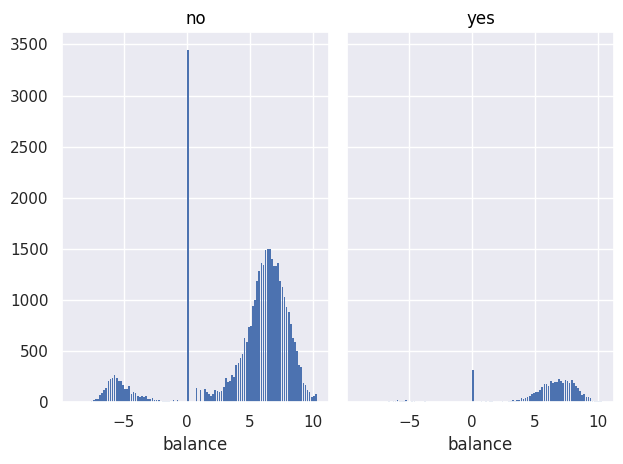

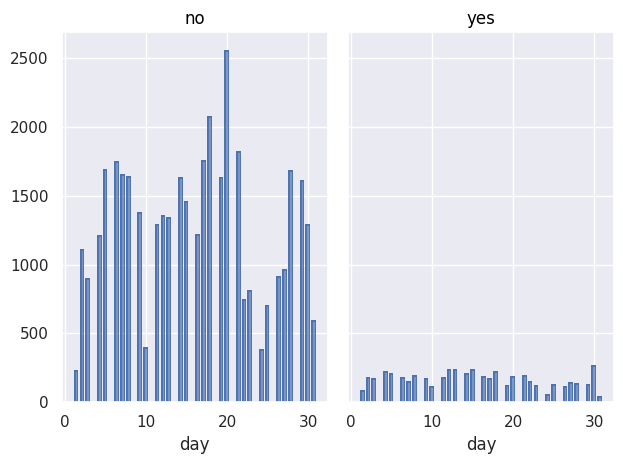

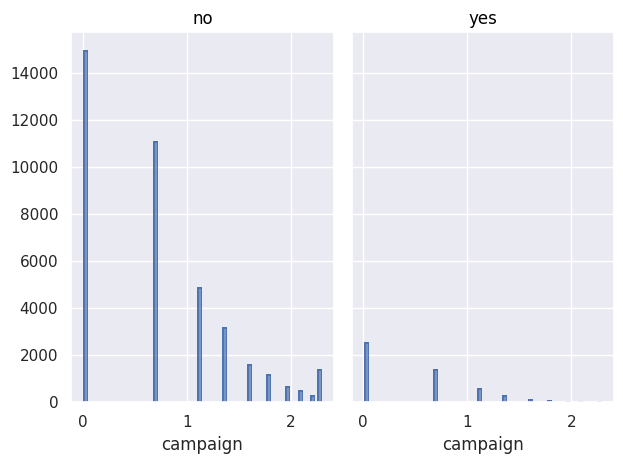

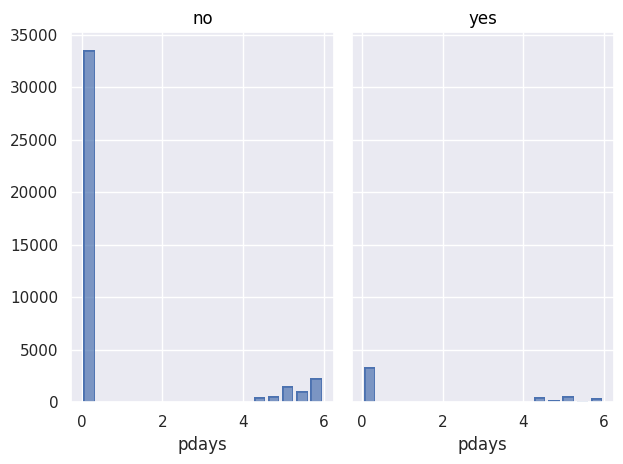

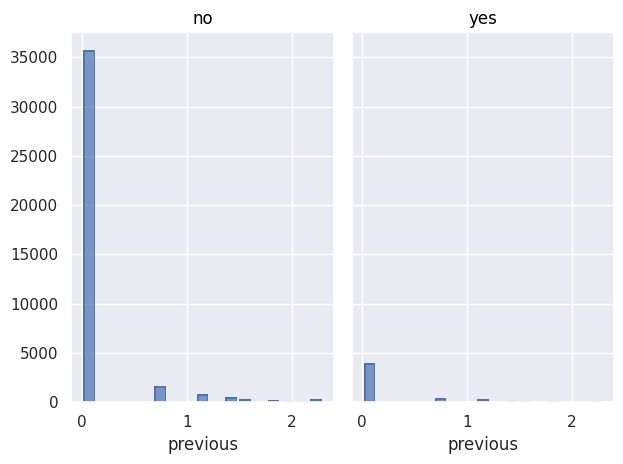

In [ ]:
def y_hist(feat):
  so.Plot(df, feat).facet("y").add(so.Bar(), so.Hist()).show()

for x in numerical:
  y_hist(x)

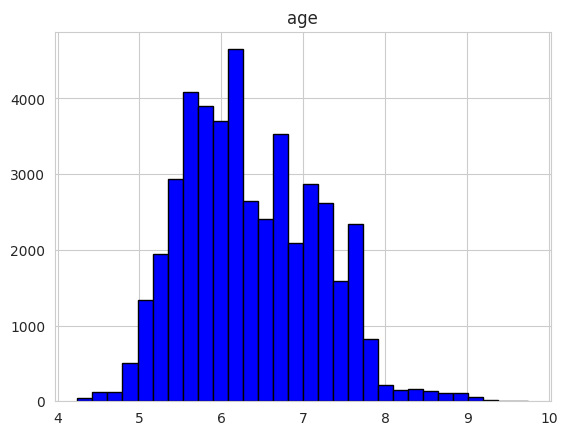

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


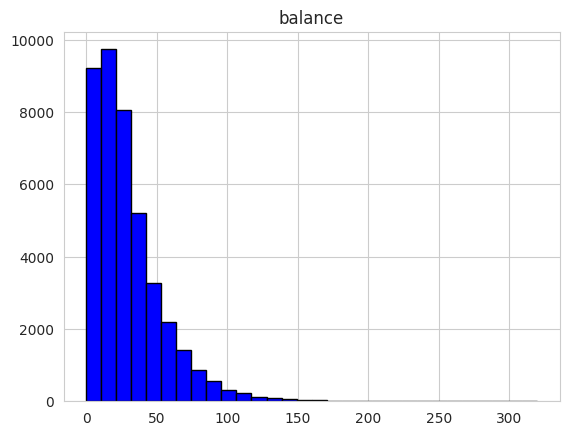

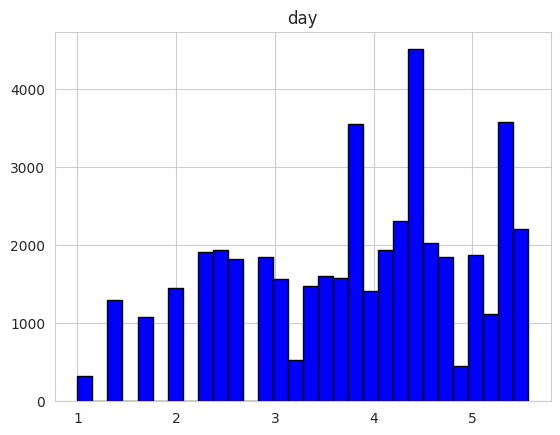

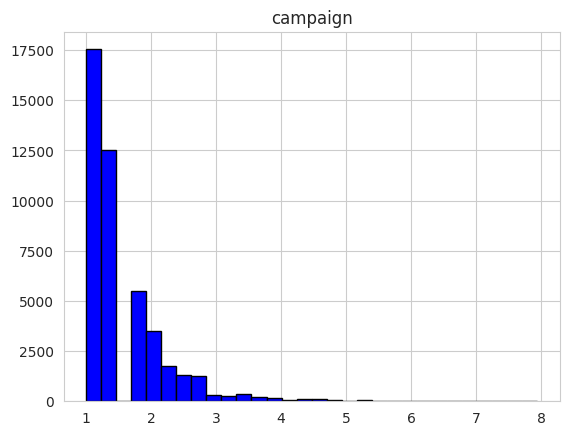

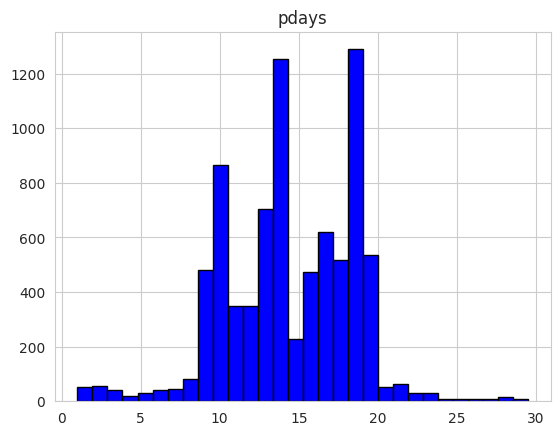

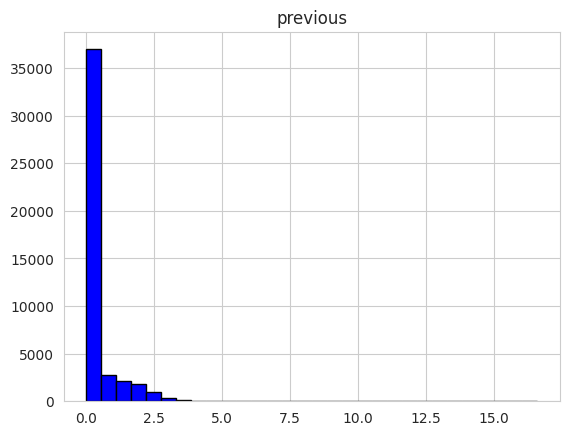

In [ ]:
def sqrt_hist(feat):
  plt.hist(np.sqrt(df[feat]), bins=30, color='blue', edgecolor='black')
  plt.title(feat)
  plt.show()

for x in numerical:
  sqrt_hist(x)

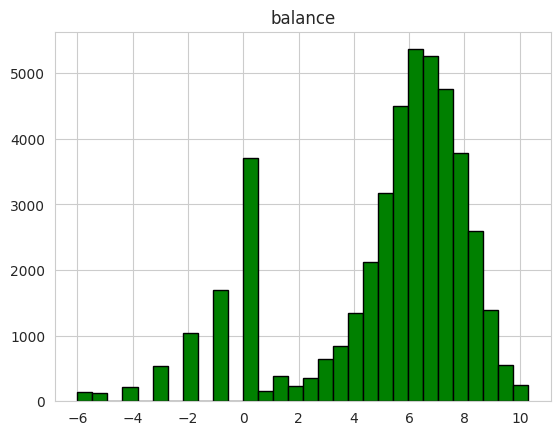

In [ ]:
def log_hist(feat):
  if feat == 'balance' or feat == 'previous':
    plt.hist([math.log(x) if x > 0 else 0 if x == 0 else x for x in df[feat]], bins=30, color='green', edgecolor='black')
  else:
    plt.hist(np.log(df[feat]), bins=30, color='green', edgecolor='black')
  plt.title(feat)
  plt.show()

for x in numerical:
  log_hist(x)

####Box Plots
- Box Plots for all numerical features to identify outliers

In [ ]:
for index, column in enumerate(numerical, 1):
    plt.subplot(4, 5, index)  # Adjust grid dimensions (4x5) based on the number of columns
    sns.boxplot(y=df[column])
    plt.title(column)
    plt.tight_layout()

####Pie Chart and Bar Chart
- Looking at categorical features
- Pie Chart to look at percentage of values with **yes** outcomes
- Bar Chart to look at total numbers for each feature, and to specifically look at the difference in **yes** outcome versus **no** outcome

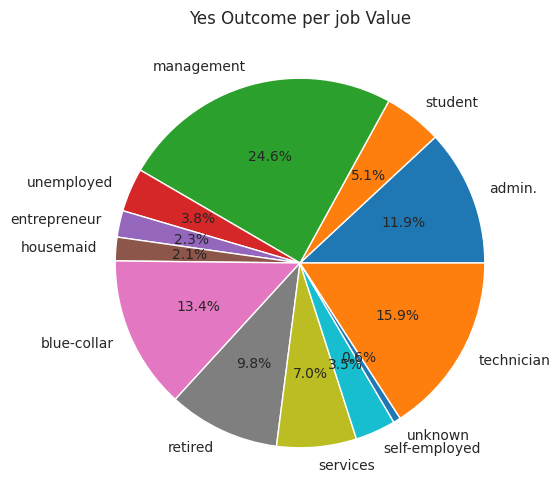

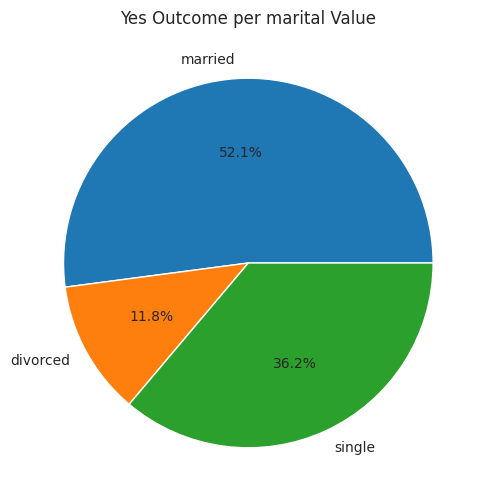

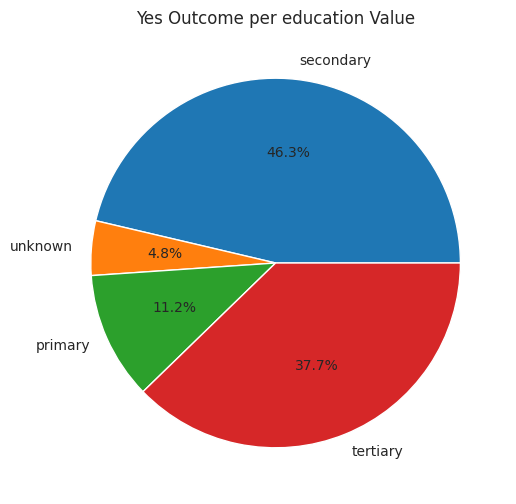

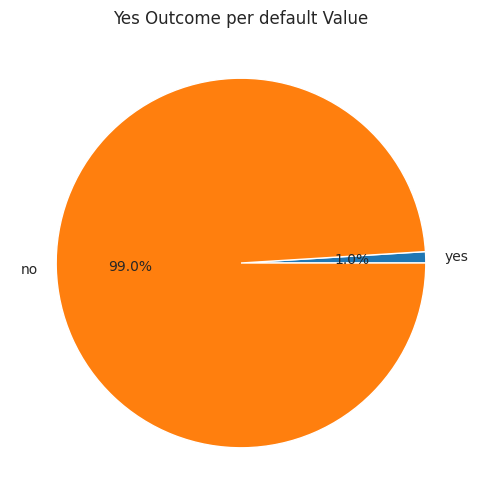

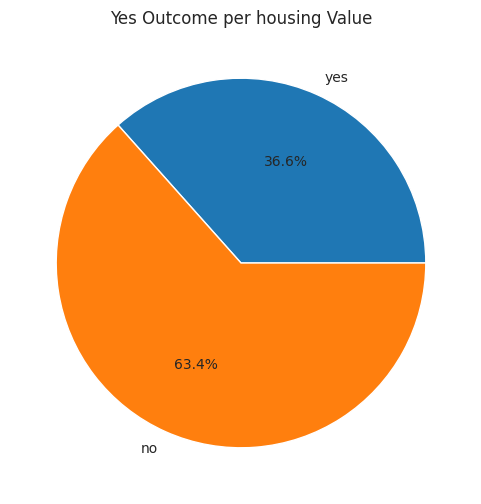

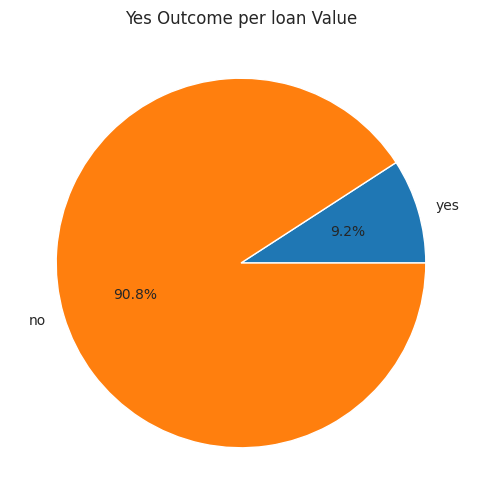

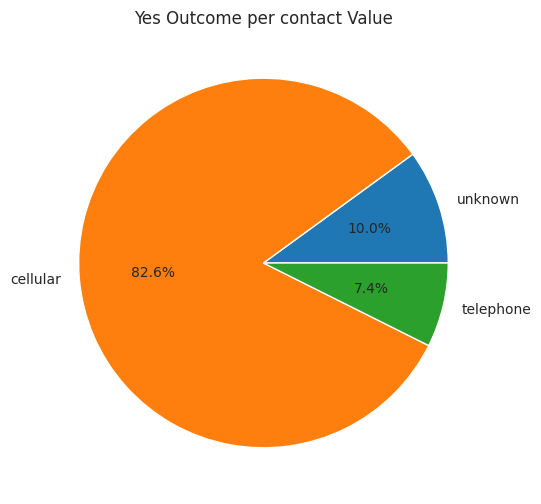

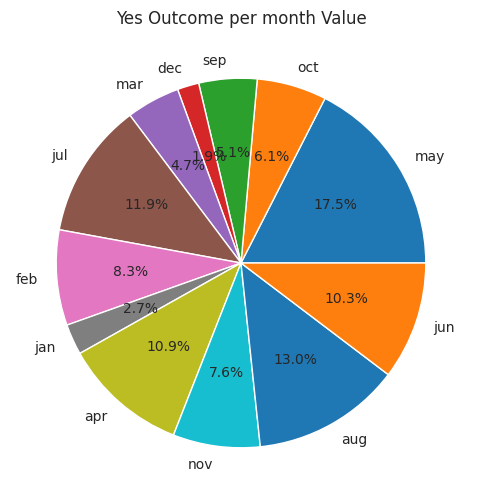

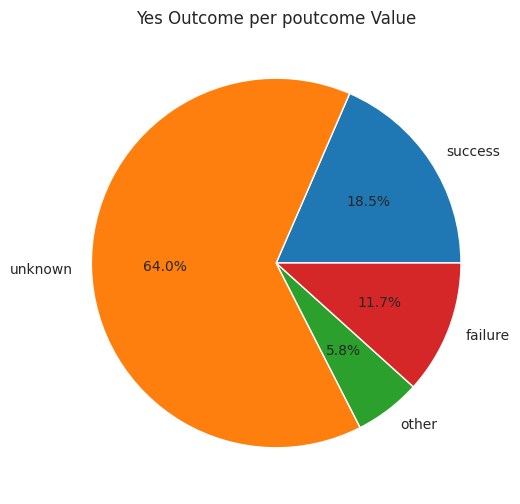

In [ ]:
def pie_chart(feat):
  feature_dict = {k:0 for k in set([j for j in df[feat]])}
  for index, feature_val in enumerate(df[feat]):
    if df.iloc[index, 16] == 'yes':
      feature_dict[feature_val] += 1

  sns.set_style("whitegrid")
  plt.figure(figsize=(6,6))
  plt.pie(feature_dict.values(), labels=feature_dict.keys(), autopct='%1.1f%%')
  plt.title('Yes Outcome per '+feat+" Value")
  plt.show()

for x in categorical:
  pie_chart(x)

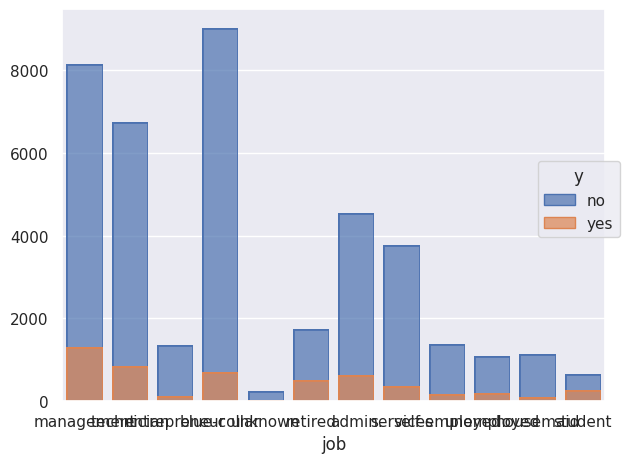

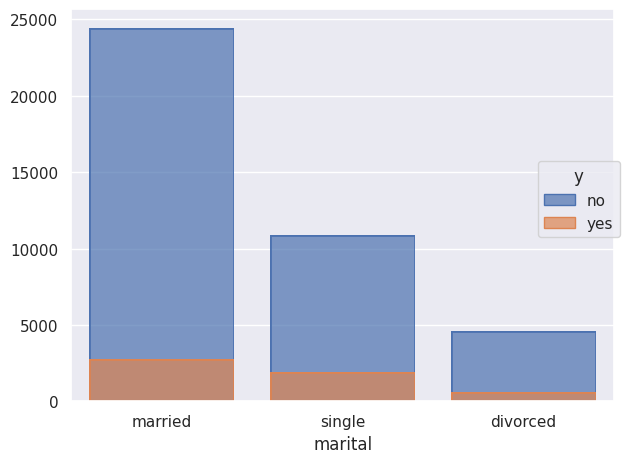

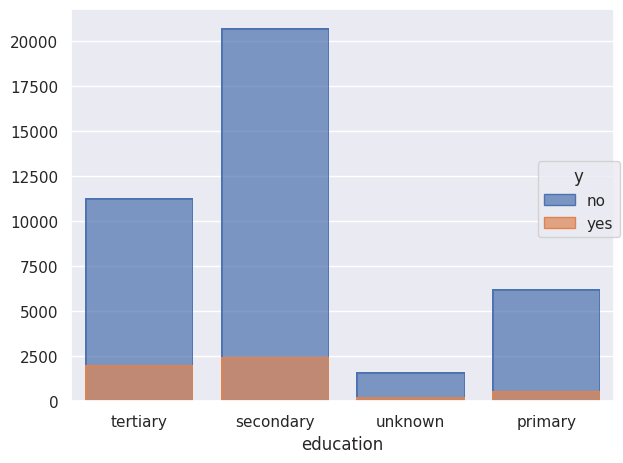

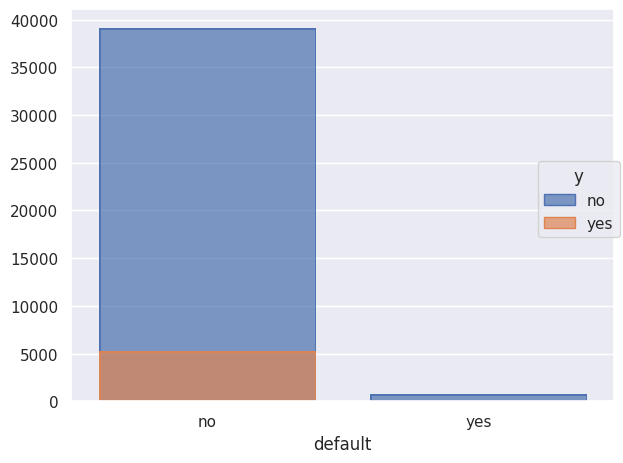

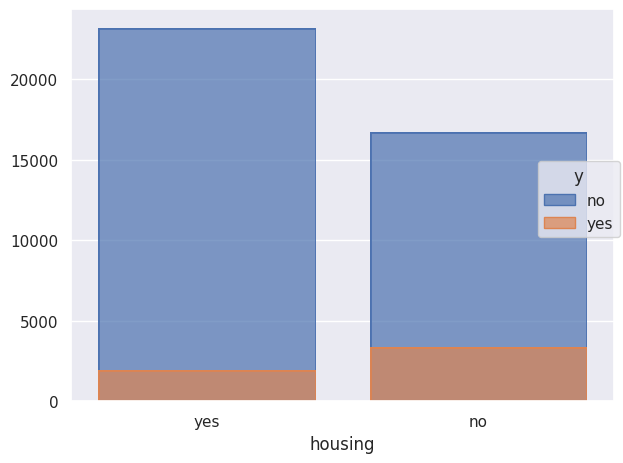

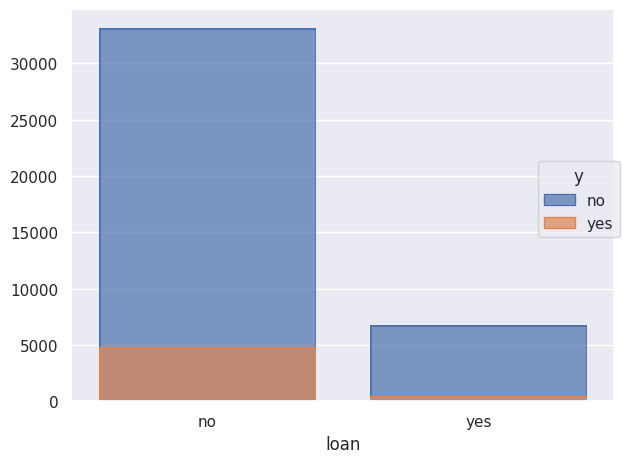

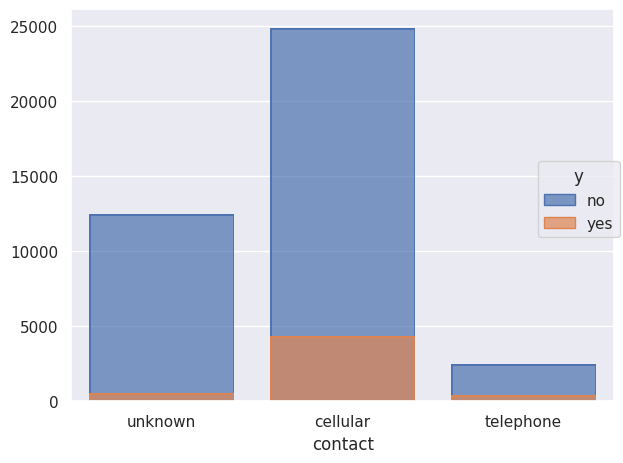

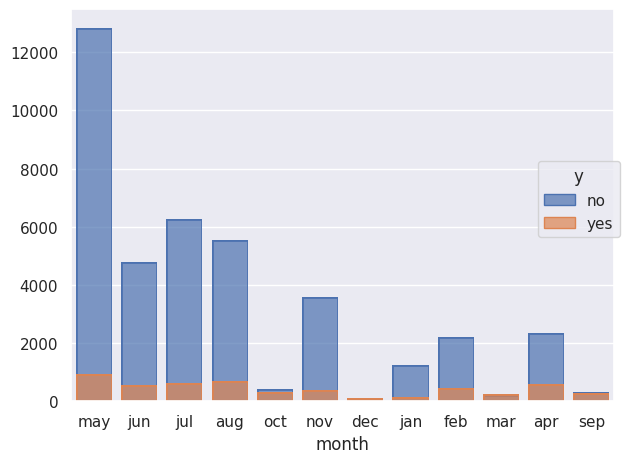

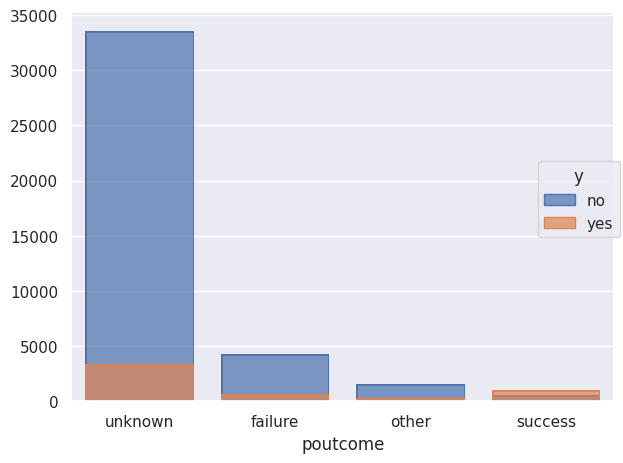

In [ ]:
def bar_chart(feat):
  so.Plot(df, x=df[feat], color="y").add(so.Bar(), so.Count()).show()

for x in categorical:
  bar_chart(x)

####Feature Exploration
- Create deep copy of dataframe
- Bin numerical features to transform them into categorical
- For each feature, print out **yes** percentage for each value
- Determine if there is a significant difference in value outcomes

In [ ]:
df_categorical = df.copy()
df_categorical.drop(columns='duration', inplace=True)

df_categorical['age'] = ['<30' if x<30 else '30-40' if x<40 else '40-50' if x<50 else '50-60' if x<60 else '60-70' if x<70 else '70-80' if x<80 else '>80' for x in df['age']]
df_categorical['balance'] = ['in debt' if x<0 else '<1000' if x<1000 else '1000-5000' if x<5000 else '5000-20000' if x<20000 else '20000-30000' if x<30000 else '>30000' for x in df['balance']]
df_categorical['previous'] = ['0-5' if x<6 else '6-10' if x<11 else '11-15' if x<16 else '16+' for x in df['previous']]
df_categorical['campaign'] = ['0-4' if x<5 else '5-9' if x<10 else '10-14' if x<15 else '15+' for x in df['campaign']]
df_categorical['pdays'] = ['-1' if x==-1 else '0-10' if x<11 else '10-50' if x<51 else '50-100' if x<101 else '100+' for x in df['pdays']]

In [ ]:
categorical_features = df_categorical.columns.tolist()
feature_percentage = []
for x in categorical_features:
  feature_percentage.append((x, {k:0 for k in set([j for j in df_categorical[x]])}))
for i, feature in enumerate(feature_percentage):
  for index, x in enumerate(df_categorical[feature[0]]):
    if df_categorical.iloc[index, 15] == 'yes':
      feature_percentage[i][1][x] += 1
  for x in feature_percentage[i][1].keys():
    feature_percentage[i][1][x] = feature_percentage[i][1][x]/list(df_categorical[feature[0]]).count(x)*100
for x in feature_percentage:
  print(x[0],": ",x[1])

# Changes in percentage after KNN Imputation

#'job', {'student': 22.61904761904762, 'retired': 23.47826086956522, 'self-employed': 10.92896174863388,
#'technician': 10.807291666666668, 'management': 13.519091847265221, 'unemployed': 10.15625, 'unknown': 18.421052631578945,
#'services': 9.112709832134293, 'housemaid': 12.5, 'entrepreneur': 8.928571428571429,
#'blue-collar': 7.293868921775898, 'admin.': 12.133891213389122}

#('job', {0: 12.133891213389122, 1: 10.15625, 2: 13.491246138002062, 3: 13.675213675213676, 4: 8.426966292134832,
#5: 23.91304347826087, 6: 7.43455497382199, 7: 10.695187165775401, 8: 23.47826086956522, 9: 10.807291666666668, 10: 9.112709832134293}

#'education', {'tertiary': 14.296296296296296, 'secondary': 10.624457935819601, 'unknown': 10.16042780748663, 'primary': 9.43952802359882}
#'education', {0: 9.465020576131687, 1: 10.606060606060606, 2: 14.296296296296296}

age :  {'<30': 17.59908970225678, '>80': 42.30769230769231, '60-70': 29.67479674796748, '40-50': 9.120549120549121, '70-80': 42.45283018867924, '50-60': 9.334126040428062, '30-40': 10.57548786555365}
job :  {'admin.': 12.202668729452718, 'student': 28.678038379530918, 'management': 13.755550856417848, 'unemployed': 15.502686108979278, 'entrepreneur': 8.271687962340282, 'housemaid': 8.790322580645162, 'blue-collar': 7.274969173859433, 'retired': 22.791519434628977, 'services': 8.883004333172845, 'self-employed': 11.842938568714375, 'unknown': 11.805555555555555, 'technician': 11.056996182703699}
marital :  {'married': 10.123465863158668, 'divorced': 11.945458037257538, 'single': 14.94917904612979}
education :  {'secondary': 10.559434531505904, 'unknown': 13.5702746365105, 'primary': 8.626477886439936, 'tertiary': 15.006390496955117}
default :  {'yes': 6.38036809815951, 'no': 11.796107757455626}
balance :  {'20000-30000': 14.184397163120568, '<1000': 10.543595866134387, '>30000': 17.3076

####Noise Reduction
- Bin the outliers so that they do not cause noise or overfitting in the model
  - Logistic Regression: +0.2
  - Decision Tree: -.1
  - Random Forest: +0.2

In [107]:
# just balance and pdays for Random Forest and Decision Tree
df['balance'] = [30000 if x>30000 else x for x in df['balance']]
df['pdays'] = [400 if x>400 else x for x in df['pdays']]

In [ ]:
# all for Logistic Regression
df['balance'] = [30000 if x>30000 else x for x in df['balance']]
df['pdays'] = [400 if x>400 else x for x in df['pdays']]
df['campaign'] = [10 if x>10 else x for x in df['campaign']]

#Feature Engineering
- Logarithmic Transformation
- Categorical Encoding
- KNN Imputation
- Min/Max Scaling
- Feature Selection

###Logarithmic Transformation
- Scale the right-skewed features -> most important for logistic regression model
- Note: cannot take log of 0 or a negative number, so keep each value of 0 at 0 and log the absolute value of any negative number and then multiply by -1
- Slight increase for all models
  - Logistic Regression: +0.69
  - Decision Tree: -0.3
  - Random Forest: -0.06

In [108]:
# just balance and age for Random Forest and Decision Tree
df['balance'] = [math.log(x) if x > 0 else 0 if x == 0 else -math.log(abs(x)) for x in df['balance']]
df['age'] = np.log(df['age'])

In [ ]:
# all for Logistic Regression
df['balance'] = [math.log(x) if x > 0 else 0 if x == 0 else -math.log(abs(x)) for x in df['balance']]
df['age'] = np.log(df['age'])
df['pdays'] = [math.log(x) if x > 0 else 0 for x in df['pdays']]
df['campaign'] = np.log(df['campaign'])

###Categorical Encoding
- Label Encoding for all categorical features with no unknown values
- manual categorical encoding for features with small percentage of unknown values -> manually input math.nan to later KNN impute
- This is necessary because models cannot compute data with strings

In [109]:
label_encoder = LabelEncoder()

categorical = df.select_dtypes(include=['object']).columns.tolist()
categorical.remove("job")
categorical.remove("education")
for feature in categorical:
  df[feature] = label_encoder.fit_transform(df[feature])

In [110]:
job_mapping = {"admin.":0,"unknown":math.nan,"unemployed":1,"management":2,"housemaid":3,"entrepreneur":4,"student":5,
                                       "blue-collar":6,"self-employed":7,"retired":8,"technician":9,"services":10}
education_mapping = {"unknown":math.nan,"primary":0,"secondary":1,"tertiary":2}

df['job'] = df['job'].map(job_mapping)
df['education'] = df['education'].map(education_mapping)

###KNN Imputing
- impute missing job and education data based on the rest of the features
  - Logistic Regression: +0.0
  - Decision Tree: +0.1
  - Random Forest: +0.01

In [111]:
imputer = KNNImputer(n_neighbors=5)
job_imputed = imputer.fit_transform(df[["job", "age", "marital", "default", 'balance', 'housing', 'loan', 'day', 'month', 'campaign', 'pdays', 'previous']])
education_imputed = imputer.fit_transform(df[["education", "job", "age", "marital", "default", 'balance', 'housing', 'loan', 'day', 'month', 'campaign', 'pdays', 'previous']])

In [112]:
df['job'] = job_imputed[:,0].astype('int64')
df['education'] = education_imputed[:,0].astype('int64')

###Scaling
- min/max scale all the features to make the values between 0 - 1, so that they can be compared equally
  - Logistic Regression: +0.2
  - Decision Tree: +0.01
  - Random Forest: -.02

In [113]:
# Min/Max Scaling

mscaler = MinMaxScaler()
for feature in df.columns.tolist():
  df[feature] = mscaler.fit_transform(df[[feature]])

###Correlation Matrix
- Create correlation matrix to determine if any features are highly correlated
- features with negative values are not correlated
- features with a value close to 1 are strongly correlated

** pdays and previous have a strong correlation of 0.7

In [ ]:
correlation_matrix = df.corr()
print(correlation_matrix)

###PCA (Principal Component Analysis)
- For reducing dimensionality
- The chart shows how many components to choose - the lowest number with a cumulative variance of at least 95%
- Problem: PCA works best for datasets with a lot of dimensionality. Because the original dataset is small, the new dataset caused overfitting, resulting in a lower accuracy score

In [ ]:
pca = PCA().fit(df.drop(columns=["y", "duration"]))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
pca = PCA(n_components=8)
pca_results = pca.fit_transform(df.drop(columns=["y", "duration"]))
print(pca_results)

#Modeling
- split train, test and validation sets
- fit model
- predict y
- test accuracy

###Split dataset
- split data 80/20 train set v test set
- split test set 50/50 to create a validation set

####Smote
- Applying smoting (ADASYN) to data because of severe sampling imbalance
- Only use for Random Forest and Decision Tree
  - Decision Tree: +6.9
  - Random Forest: +4.7

In [121]:
X = df.drop(columns=['y', 'duration'])
#X = pca_results
y = df['y']

ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X, y)

#Decision Tree and Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#Logistic Regression
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_lg, X_val_lg, y_test_lg, y_val_lg = train_test_split(X_test_lg, y_test_lg, test_size=0.2, random_state=42)

###Logistic Regression Model
- Preprocessing:
  - Categorical Encoding
  - Min/Max Scaling
  - KNN Imputation (job, education)
  - Binning Outliers (balance, pdays, campaign)
  - Log Transformation (balance, pdays, campaign, age)
- Model Optimization:
  - Feature Selection (exclude education, previous, contact, age, loan, default)
  - Hyperparameter Tuning (max_iter=1000, multi_class='ovr', solver='sag', tol=0.001, C=5)

Baseline Accuracy: 87.78%<br/>
Final Accuracy: 89.02%<br/>
Accuracy Gain: 1.24%

In [ ]:
# Initialize the logistic regression model
#logreg_model = LogisticRegression(random_state=42)
logreg_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr', solver='sag', tol=0.001, C=5)

#'education','age','contact','previous']
# Fit the model to the training data
#logreg_model.fit(X_train_lg, y_train_lg)
logreg_model.fit(X_train_lg.drop(columns=['education','age','contact','previous', 'loan', 'default']), y_train_lg)

# Predict the target variable for the testing set
#y_pred_lg = logreg_model.predict(X_test_lg)
y_pred_lg = logreg_model.predict(X_test_lg.drop(columns=['education','age','contact','previous', 'loan', 'default']))

# Calculate accuracy
accuracy = accuracy_score(y_test_lg, y_pred_lg)*100
print("Accuracy:", accuracy)

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_pred_lg, y_test_lg)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()


# No Validation Set:
# Baseline (Categorical Encoding) : 87.78060378193078
# Categorical Encoding and Scaling: 87.99071104721884 (0.2%)
# Categorical Encoding, Scaling, KNN Imputation: 87.99071104721884 (0%)
# Categorical Encoding, Scaling, KNN Imputation, Noise Reduction(balance, pdays, campaign): 88.20081831250691 (0.2%)
# Categorical Encoding, Scaling, KNN Imputation, Noise Reduction, Log(balance, pdays, campaign, age): 88.89748977109366 (0.69%)
# Preprocessing and Feature Exclusion: 88.96383943381622 (0.1%)
# Preprocessing, Feature Exclusion, and Hypterparameter Tuning: 89.01913081941834 (0.05%)

# With Validation Set:
# Baseline (Categorical Encoding): 87.98728227813105
# Preprocessing, Feature Exclusion, and Hypterparameter Tuning: 89.27287807575338 (+1.29)

In [ ]:
# Valedation Set

# Predict the target variable for the validation set
#y_pred_lg = logreg_model.predict(X_val_lg)
y_pred_lg = logreg_model.predict(X_val_lg.drop(columns=['education','age','contact','previous', 'loan', 'default']))

# Calculate accuracy
accuracy = accuracy_score(y_val_lg, y_pred_lg)*100
print("Accuracy:", accuracy)

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_pred_lg, y_val_lg)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()


# Baseline (Categorical Encoding): 86.95411829740188
# Preprocessing, Feature Exclusion, and Hypterparameter Tuning: 88.00442233278054 (+1.1)

###Decision Tree Model
- Preprocessing:
  - Categorical Encoding
  - Min/Max Scaling
  - KNN Imputation (job, education)
  - Binning Outliers (balance, pdays)
  - Log Transformation (balance, age)
  - ADASYN Adaptive Synthetic Sampling
- Model Optimization:
  - Feature Selection (exclude balance, previous, default, age, marital)
  - Hyperparameter Tuning (criterion=entropy, min_samples_split=7)

Baseline Accuracy: 82.28%<br/>
Final Accuracy: 90.82%<br/>
Accuracy Gain: 8.53%

In [ ]:
# Initialize the decision tree model
#dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', min_samples_split=7)

# Fit the model to the training data
# Drop unwanted columns
#dt_classifier.fit(X_train, y_train)
dt_classifier.fit(X_train.drop(columns=['balance', 'previous', 'default', 'age', 'marital']), y_train)

# Predict the target variable for the testing set
#y_pred_dt = dt_classifier.predict(X_test)
y_pred_dt = dt_classifier.predict(X_test.drop(columns=['balance', 'previous', 'default', 'age', 'marital']))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_dt)*100
print("Accuracy:", accuracy)

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_pred_dt, y_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()


# No Validation Set:
# Baseline (Categorical Encoding): 82.28464005307973
# Categorical Encoding and Scaling: 82.29569833020015 (0.01)
# Categorical Encoding, Scaling, KNNImputation: 82.4062811014044 (0.1)
# Categorical Encoding, Scaling, KNN Imputation, Noise Reduction(balance, pdays): 82.24040694459803 (-.1)
# Categorical Encoding, Scaling, KNN Imputation, Noise Reduction(balance, pdays), Log(balance, age): 81.89760035386486 (-.3)
# Preprocessing and ADASYN: 88.85840763139846 (6.9)
# Preprocessing, ADASYN, and Feature Exclusion: 90.27994263981545 (1.4)
# Preprocessing, ADASYN, Feature Exclusion and Hyperparameter Tuning: 90.81613566930606 (0.53)

# With Validation Set:
# Baseline (Categorical Encoding): 83.01260783012607
# Preprocessing, ADASYN, Feature Exclusion and Hyperparameter Tuning: 90.93403167477241 (+7.9)

In [ ]:
# Valedation Set

# Predict the target variable for the validation set
#y_pred_dt = dt_classifier.predict(X_val)
y_pred_dt = dt_classifier.predict(X_val.drop(columns=['balance', 'previous', 'default', 'age', 'marital']))

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_dt)*100
print("Accuracy:", accuracy)

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_pred_dt, y_val)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()


# Baseline (Categorical Encoding): 81.55683325961963
# Preprocessing, ADASYN, Feature Exclusion and Hyperparameter Tuning: 90.69825436408978 (+9.1)

###Random Forest Model
- Preprocessing:
  - Categorical Encoding
  - Min/Max Scaling
  - KNN Imputation (job, education)
  - Binning Outliers (balance, pdays)
  - Log Transformation (balance, age)
  - ADASYN Adaptive Synthetic Sampling
- Model Optimization:
  - Hyperparameter Tuning (n_estimators=100)

Baseline Accuracy: 89.18%<br/>
Final Accuracy: 94.21%<br/>
Accuracy Gain: 5.02%

In [ ]:
# Initialize the random forest model
#rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
#{'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Predict the target variable for the testing set
y_pred_rf = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_rf)*100
print("Accuracy:", accuracy)

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_pred_rf, y_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()


# No Validation Set:
# Baseline (Categorical Encoding): 89.1850049762247
# Categorical Encoding and Scaling: 89.16288842198385 (-.02)
# Categorical Encoding, Scaling, KNN Imputation: 89.17394669910428 (+0.01)
# Categorical Encoding, Scaling, KNN Imputation, Noise Reduction(Balance, pdays): 89.38405396439235 (+0.2)
# Categorical Encoding, Scaling, KNN Imputation, Noise Reduction(Balance, pdays), log transform(balance, age): 89.3177043016698 (-0.06)
# Preprocessing and ADASYN: 94.08940707026623 (+4.7)
# Preprocessing, ADASYN, Hyperparameter Tuning: 94.20786832096764 (+0.1)

# With Validation Set:
# Baseline (Categorical Encoding): 89.98009289980094
# Preprocessing, ADASYN, Hyperparameter Tuning: 94.06409776780147 (+4.1)

In [ ]:
# Valedation Set

# Predict the target variable for the valedation set
y_pred_rf = rf_classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_rf)*100
print("Accuracy:", accuracy)

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_pred_rf, y_val)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()


# Baseline (Categorical Encoding): 88.39009287925697
# Preprocessing, ADASYN, Hyperparameter Tuning: 94.35162094763092 (+5.9)

#Optimization
- Feature Selection
- Hyperparameter Tuning

###Feature Selection
- For each model, test accuracy with one feature omitted
- If omitting the feature results in a higher accuracy, omit feature in model
  - Logistic Regression: +0.1
  - Decision Tree: +1.4
  - Random Forest: +0.0

In [ ]:
#Logistic Regression

features = [x for x in df.columns.tolist() if x != 'y' and x != 'duration']
for f in features:
  X_op = df.drop(columns=['y', 'duration', f])
  y_op = df['y']

  X_train_op, X_test_op, y_train_op, y_test_op = train_test_split(X_op, y_op, test_size=0.2, random_state=42)

  logreg_model = LogisticRegression(random_state=42)
  logreg_model.fit(X_train_op, y_train_op)
  y_pred_op = logreg_model.predict(X_test_op)

  # Calculate accuracy
  accuracy = accuracy_score(y_test_op, y_pred_op)
  if accuracy > 0.8889748977109366:
    print("Better than preprocessed: ", f, accuracy)

#Better than preprocessed:  age 0.8890854804821409
#Better than preprocessed:  education 0.8891960632533451
#Better than preprocessed:  contact 0.8890854804821409
#Better than preprocessed:  previous 0.8891960632533451
#Better than preprocessed:  loan 0.8897489771093664
#Better than preprocessed:  default 0.8893066460245493

In [ ]:
#Decision Tree

features = [x for x in df.columns.tolist() if x != 'y' and x != 'duration']
for f in features:
  X_op = df.drop(columns=['y', 'duration', f])
  y_op = df['y']

  ada = ADASYN(random_state=42)
  X_res_op, y_res_op = ada.fit_resample(X_op, y_op)

  X_train_op, X_test_op, y_train_op, y_test_op = train_test_split(X_res_op, y_res_op, test_size=0.2, random_state=42)

  dt_classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', min_samples_split=7)
  dt_classifier.fit(X_train_op, y_train_op)
  y_pred_op = dt_classifier.predict(X_test_op)

  # Calculate accuracy
  accuracy = accuracy_score(y_test_op, y_pred_op)
  if accuracy > 0.8843205288101771:
    print("Better than preprocessed: ", f, accuracy)

#Better than preprocessed:  age 0.8853205288101771
#Better than preprocessed:  marital 0.8859839781407192
#Better than preprocessed:  default 0.8871481180950003
#Better than preprocessed:  balance 0.8881533753825017
#Better than preprocessed:  previous 0.8865779776403723

In [114]:
#Random Forest

features = [x for x in df.columns.tolist() if x != 'y' and x != 'duration']
for f in features:
  X_op = df.drop(columns=['y', 'duration', f])
  y_op = df['y']

  ada = ADASYN(random_state=42)
  X_res_op, y_res_op = ada.fit_resample(X_op, y_op)

  X_train_op, X_test_op, y_train_op, y_test_op = train_test_split(X_res_op, y_res_op, test_size=0.2, random_state=42)

  rf_classifier = RandomForestClassifier(random_state=42)
  rf_classifier.fit(X_train_op, y_train_op)
  y_pred_op = rf_classifier.predict(X_test_op)

  # Calculate accuracy
  accuracy = accuracy_score(y_test_op, y_pred_op)*100
  if accuracy > 94.08940707026623:
    print("Better than preprocessed: ", f, accuracy)

###Grid Search Hyperparameter Tuning
- Run Grid Search on an array of hyperparameters to figure out which hyperparameter combination leads to the best model
- Problem: Grid Search led to overfitting, so proposed hyperparameters resulted in a less accurate model
- Solution: Plug in hyperparameters one by one to test if accuracy increases/decreases
  - Logistic Regression: +0.05
  - Decision Tree: +0.53
  - Random Forest: +0.1

In [ ]:
# Logistic Regression -> Grid Search

# Define hyperparameters grid
# Go through documentation to find parameters and how they can be altered
# key is the hyperparameter and the array is full of options
param_lg_grid = {'C':[1, 0.1, 5, 3, 10],
                 'penalty': ['l1', 'elasticnet', 'l2'],
                 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                 'multi_class': ['auto', 'ovr', 'multinomial']}

# Initialize GridSearchCV
# pass model, list of parameter, and number of permiatations
grid_lg_search = GridSearchCV(LogisticRegression(), param_lg_grid, cv=5)

# Perform grid search
grid_lg_search.fit(X_train.drop(columns=['education', 'contact', 'age', 'previous']), y_train)
#grid_lg_search.fit(X_train, y_train)

# Get the best hyperparameters
best_lg_params = grid_lg_search.best_params_
print(best_lg_params)

#{'C': 0.001, 'max_iter': 1000, 'penalty': None, 'solver': 'sag', 'tol': 0.1}: 0.8939226519337017
#{'C': 0.0001, 'max_iter': 10000, 'multi_class': 'ovr', 'penalty': None, 'solver': 'sag', 'tol': 0.1}: 0.8939226519337017
#{'C': 0.1, 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': None, 'solver': 'sag', 'tol': 0.1}: 0.8889748977109366

In [ ]:
# Initialize and train logistic regression model with best hyperparameters
best_lg_model = LogisticRegression(**best_lg_params, random_state=42)
best_lg_model.fit(X_train.drop(columns=['education', 'contact', 'age', 'previous']), y_train)
#best_lg_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = best_lg_model.predict(X_test.drop(columns=['education', 'contact', 'age', 'previous']))
#y_pred = best_lg_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Accuracy: 88.89748977109366

In [ ]:
# Random Forest -> Halving Grid Search

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_rf_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [8,9,10,11,12],
              'max_features': ['log2', 'sqrt'],
              'n_estimators': [10, 100, 1000],
              'min_samples_split': [8, 9, 10, 11, 12],
              'min_samples_leaf': [1, 2, 4]}

half_rf_search = HalvingGridSearchCV(RandomForestClassifier(random_state=42), param_rf_grid, random_state=42)
half_rf_search.fit(X_train, y_train)
best_rf_params = half_rf_search.best_params_
print(best_rf_params)
#{'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}

In [ ]:
# Random Forest -> Grid Search

# Define hyperparameters grid
param_rf_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [8,9,10,11,12, None],
              'max_features': ['log2', 'sqrt' None],
              'n_estimators': [10, 100, 1000],
              'min_samples_split': [8, 9, 10, 11, 12],
              'min_samples_leaf': [1, 2, 4]}

# Initialize GridSearchCV
grid_rf_search = GridSearchCV(RandomForestClassifier(), param_rf_grid, cv=5)

# Perform grid search
grid_rf_search.fit(X_train, y_train)

# Get the best hyperparameters
best_rf_params = grid_rf_search.best_params_
print(best_rf_params)
#{'criterion': 'log_loss', 'max_depth': 10, 'min_samples_split': 11}

In [ ]:
# Initialize and train logistic regression model with best hyperparameters
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Accuracy: 90.05524861878453

#Conclusion
The three models used were Logistic Regression, Decision Tree and Random Forest. The baseline accuracy for the models was 87.78% for Logistic Regression, 82.28% for Decision Tree and 89.18% for Random Forest. The baseline accuracy was based off simply ingesting the dataset and categorical encoding the categorical features.

Once a baseline accuracy was established, EDA was conducted to determine next steps in preprocessing the data. Looking at the percentage of missing values (denoted as **unknown** in the categorical features) led to the discovery that _job_ and _education_ had a small enough percentage that KNN Imputation would be beneficial. KNN Imputation was implemented by manually encoding the _job_ and _education_ columns, replacing **unknown** with **math.nan** and then using KNNImputation to fill in the null values.

The histograms revealed that many of the numerical features were strongly right-skewed, and performing a log or square root transformation normalized the distribution. A problem arose because 'balance' has both 0 and negative values, so the 0 values were left as is, and the negative values were transformed in their absolute value and then changed back to negative.

The boxplots, along with the statistics from df.describe(), revealed that both _balance_ and _pdays_ had very large standard deviations, so the outliers were binned before the features were transformed.

The numerical features were then binned so that they would become categorical features, and then for each feature, the percentage of **yes** outcome was calculated for each value. This reveal any variation between the values in terms of a **yes** outcome and whether they would be helpful to include in the model. This was also used to determine at what value outliers in _balance_ and _pdays_ should be binned.

Min/Max Scaling was applied to every feature so that the models would not favor any feature above another.

The correlation matrix and PCA were used for feature selection and dimensionality reduction. The correlation matrix revealed that _pdays_ and _previous_ were highly correlated, and therefore one of them could be dropped. PCA however did not increase the accuracy of the models because the dataset was too small to benefit from it. A for-each loop, iteratively removing one feature from the dataset and running the model, showed which feature omissions resulted in a higher accuracy score. Removing all the features suggested resulted in the highest gain.

Adaptive Synthetic Sampling (ADASYN) was applied to the dataset before test/train/validation splitting to combat the imbalanced dataset. Of the roughly 45,000 entries, about 40,000 resulted in a **no** outcome while only about 5,000 resulted in **yes**. While the Decision Tree and Random Forest models strongly benefitted from this, the accuracy of the Logistic Regression model plummeted to 60%, and therefore ADASYN was not applied to the Logistic Regression dataset.

Finally, a Grid Search and Halved Grid Search was used to tune the hyperparameters. Unfortunately, the suggested hyperparameters resulted in overfitting, leading to less accurate scores, so tuning was performed manually.

The final accuracy scores were 89.02% for Logistic Regression with a gain of 1.24, 90.82% for Decision Tree with a gain of 8.53, and 94.21% for Random Forest with a gain of 5.02. The confusion matrix revealed that the Logistic Regression model's lack of substantial progress was due to the model rarely predicting **yes**. ADASYN helped combat this problem in the other two models.
